In [1]:
import abc

import numpy as np
import matplotlib.pyplot as plt

from config import DATA_FOLDER

%matplotlib inline

# Introduction

This notebook shows the implementation of multilayer perceptron (MLP) models with the backpropagation algortithm. To do so, the following classes are defined.

1. `Layer`: an abstract class for a layer of a neural network. It defines the basic methods `forward()`  and `backward()`.
2. `Inputlayer`: a class that implements the layer that receives the input of the neural network.
3. `FullyConnectedLayer`: a class that implements a fully connected layer of a neural network. It shows the update process of weights when activation function is the sigmoid or the hyperbolic tangent.
4. `SoftmaxLayer`: a class that implements a output layer (Softmax) of classification neural networks.
5. `MLP`: a class that implements a multilayer perceptron (MLP) neural network that takes a list of layers as input. The first layer must be an `InputLayer` and the last one a `SoftmaxLayer`.

In [2]:
SUPPORTED_ACTIVATION_FUNC = ["sigmoid", "tanh"]


class Layer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, input_x: np.array) -> None:
        raise NotImplementedError

    @abc.abstractmethod
    def backward(self):
        raise NotImplementedError


class FullyConnectedLayer(Layer):
    def __init__(
        self,
        n_input: int,
        n_output: int,
        random_seed: int = 42,
        activation_func: str = "sigmoid",
        add_noise: bool = False,
    ):
        self.n_input = n_input
        self.n_output = n_output
        if activation_func not in SUPPORTED_ACTIVATION_FUNC:
            raise ValueError(
                f"activation_func must be either {SUPPORTED_ACTIVATION_FUNC}"
            )
        self.activation_func = activation_func
        self.add_noise = add_noise

        # Xavier Weight Initialization.
        bound = np.sqrt(1.0 / self.n_input)
        np.random.seed(random_seed)
        self.weights = np.random.uniform(
            -bound, bound, size=(self.n_input, self.n_output)
        )

    def _sigmoid(self, x: np.array) -> np.array:
        return 1 / (1 + np.exp(-x))

    def _tanh(self, x: np.array) -> np.array:
        return (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)

    def forward(self, input_x: np.array) -> None:
        """Implement forward propagation."""
        if self.add_noise:
            input_x += np.random.normal(0, 0.05, size=input_x.shape)

        if self.activation_func == "sigmoid":
            self.out_x = self._sigmoid(input_x.dot(self.weights))
        elif self.activation_func == "tanh":
            self.out_x = self._tanh(input_x.dot(self.weights))

    def backward(
        self, x_pre: np.array, delta_next: np.array, weights_next: np.array, eta: float
    ) -> None:
        """Implement backward propagation."""
        if self.activation_func == "sigmoid":
            self.delta = (
                self.out_x * (1 - self.out_x) * np.dot(delta_next, weights_next.T)
            )
        elif self.activation_func == "tanh":
            self.delta = (1 - np.square(self._tanh(self.out_x))) * np.dot(
                delta_next, weights_next.T
            )

        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]


class InputLayer(Layer):
    def forward(self, input_x: np.array) -> None:
        self.out_x = input_x

    def backward(self) -> None:
        pass


class Softmax(Layer):
    def __init__(self, n_input: int, n_output: int, random_seed: int = 42):
        self.n_input = n_input
        self.n_output = n_output

        # Xavier Weight Initialization.
        bound = np.sqrt(1.0 / self.n_input)
        np.random.seed(random_seed)
        self.weights = np.random.uniform(
            -bound, bound, size=(self.n_input, self.n_output)
        )

    def _softmax(self, out_x: np.array) -> np.array:
        return np.exp(out_x) / np.sum(np.exp(out_x))

    def forward(self, input_x: np.array) -> None:
        """Implement forward propagation (output layer)"""
        self.out_x = np.dot(input_x, self.weights)

    def backward(self, y_true: np.array, x_pre: np.array, eta: float) -> None:
        """Implement backward propagation (output layer)."""
        pred_proba = self.pred_proba()
        # Derivative of cross entropy loss with softmax.
        self.delta = pred_proba - y_true

        self.weights -= eta * np.dot(x_pre.T, self.delta) / x_pre.shape[0]

    def pred_proba(self) -> np.array:
        """Predict probability of each class."""
        return np.apply_along_axis(self._softmax, 1, self.out_x)

    def predict_label(self) -> np.array:
        """Predict labels."""
        pred_proba = self.pred_proba()
        return (pred_proba == pred_proba.max(axis=1)[:, None]).astype(int)


class MLP:
    def __init__(self, layers: list[Layer]):
        self.layers = layers

    def forward(self, x: np.array) -> None:
        """Perform forward propagation."""
        for layer in self.layers:
            layer.forward(x)
            x = layer.out_x

    def backward(self, y_true: np.array, eta: float) -> None:
        """Perform backward propagation."""
        for i in range(len(self.layers) - 1, -1, -1):
            if isinstance(self.layers[i], Softmax):
                self.layers[i].backward(y_true, self.layers[i - 1].out_x, eta)
            elif isinstance(self.layers[i], InputLayer):
                pass
            else:
                self.layers[i].backward(
                    self.layers[i - 1].out_x,
                    self.layers[i + 1].delta,
                    self.layers[i + 1].weights,
                    eta,
                )

    def pred_proba(self) -> np.array:
        return self.layers[-1].pred_proba()

    def predict_label(self) -> np.array:
        """Predict labels."""
        return self.layers[-1].predict_label()


def mean_square_error(y_true_matrix: np.array, y_pred_matrix: np.array) -> float:
    return np.mean(np.square(y_true_matrix - y_pred_matrix))


def misclassification_rate(y_true: np.array, y_pred: np.array) -> float:
    return sum(y_true != y_pred) / len(y_pred)

# Use MLP to solve XOR Problem

In this example, we will see how to use a MLP model to solve the [XOR problem](https://www.niser.ac.in/~smishra/teach/cs460/2020/lectures/lec19/#:~:text=The%20XOr%20problem%20is%20that,we%20will%20be%20using%20perceptrons.).

In [3]:
# The first column in X is the bias term.
X = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])

In [4]:
n_neurons = 2

input_layer = InputLayer()
fc_layer = FullyConnectedLayer(X.shape[1], n_neurons)
output_layer = Softmax(n_neurons, 2)
mlp = MLP([input_layer, fc_layer, output_layer])

In [5]:
epochs = 55000
end_epoch = epochs

errors = []
for epoch in range(epochs):
    mlp.forward(X)
    mlp.backward(y, eta=0.4)
    errors.append(mean_square_error(y, mlp.pred_proba()))

    if epoch % 5000 == 0:
        print(f"Epoch {epoch}: {errors[epoch]}")

    if (
        misclassification_rate(
            np.argmax(y, axis=1), np.argmax(mlp.predict_label(), axis=1)
        )
        == 0
    ):
        end_epoch = epoch
        break

Epoch 0: 0.2542057650952129
Epoch 5000: 0.06536687001084644
Epoch 10000: 0.06321517301084355
Epoch 15000: 0.06289594949046522
Epoch 20000: 0.06276829921143066
Epoch 25000: 0.062699030375915
Epoch 30000: 0.06265472642548456
Epoch 35000: 0.06262286539479991
Epoch 40000: 0.06259728183526422
Epoch 45000: 0.06257366530618262
Epoch 50000: 0.06254635302615213


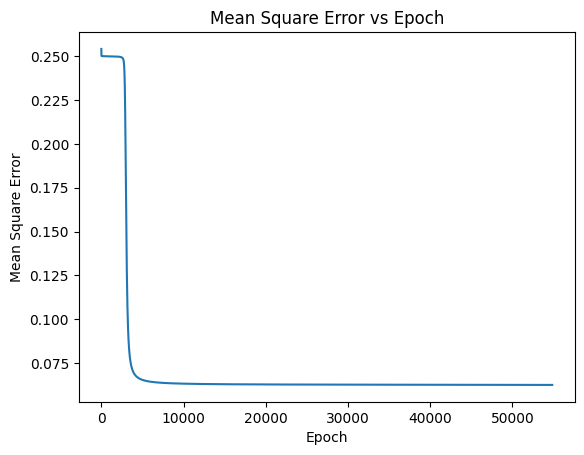

In [6]:
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.title("Mean Square Error vs Epoch")
plt.show()

# Use MLP to classify digits in mfeat-pix dataset

1. We will split the training data in mfeat-pix dataset into "training" and validation sets to pick better hyperparameters.
2. The two datesets will be merged again to train the MLP model with the optimized hyperparameters.
3. The model will be tested with the test set.

In [7]:
# Load data
X = np.loadtxt(DATA_FOLDER / "mfeat-pix.txt")
# Normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Add bias term
X = np.column_stack([np.ones(X.shape[0]), X])

# Split the dataset into training, validation and test data
train_indices = [range(0 + 200 * i, 50 + 200 * i) for i in range(10)]
val_indices = [range(50 + 200 * i, 100 + 200 * i) for i in range(10)]
test_indices = [range(100 + 200 * i, 200 + 200 * i) for i in range(10)]

X_train = X[train_indices,].reshape(500, 241)
X_val = X[val_indices,].reshape(500, 241)
X_test = X[test_indices,].reshape(1000, 241)

# Create class labels for training and validation data.
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(50)])
y_matrix = np.eye(nb_classes)[y_vector]

In [8]:
neurons_1 = 256
neurons_2 = 128
neurons_3 = 128
input_layer = InputLayer()
fc_layer1 = FullyConnectedLayer(
    X.shape[1], neurons_1, activation_func="tanh", add_noise=True
)
fc_layer2 = FullyConnectedLayer(
    neurons_1, neurons_2, activation_func="tanh", add_noise=True
)
fc_layer3 = FullyConnectedLayer(
    neurons_2, neurons_3, activation_func="tanh", add_noise=True
)
output_layer = Softmax(neurons_3, 10)

mlp = MLP([input_layer, fc_layer1, fc_layer2, fc_layer3, output_layer])

In [9]:
epochs = 500
train_miss_rates = []
val_miss_rates = []

for epoch in range(epochs):
    mlp.forward(X_train)
    mlp.backward(y_matrix, eta=0.1)
    train_miss_rates.append(
        misclassification_rate(
            np.argmax(y_matrix, axis=1), np.argmax(mlp.predict_label(), axis=1)
        )
    )
    mlp.backward(y_matrix, eta=0.1)

    mlp.forward(X_val)
    val_miss_rates.append(
        misclassification_rate(
            np.argmax(y_matrix, axis=1), np.argmax(mlp.predict_label(), axis=1)
        )
    )

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Training MSE: {train_miss_rates[epoch]}. Validation MSE: {val_miss_rates[epoch]}"
        )

Epoch 0: Training MSE: 0.956. Validation MSE: 0.62
Epoch 50: Training MSE: 0.008. Validation MSE: 0.048
Epoch 100: Training MSE: 0.0. Validation MSE: 0.052
Epoch 150: Training MSE: 0.0. Validation MSE: 0.054
Epoch 200: Training MSE: 0.0. Validation MSE: 0.048
Epoch 250: Training MSE: 0.0. Validation MSE: 0.056
Epoch 300: Training MSE: 0.0. Validation MSE: 0.064
Epoch 350: Training MSE: 0.0. Validation MSE: 0.058
Epoch 400: Training MSE: 0.0. Validation MSE: 0.078
Epoch 450: Training MSE: 0.0. Validation MSE: 0.1


In the plot below, the MSE of the training and validation sets decreased significantly in the first 100 epochs. As the number of epochs increases, the MSE of the validation set increases, which indicates that the model is overfitting. Therefore, the number of epochs for training the final model is set to 100.

/var/folders/6y/37g6x3_d0hv44_f4kt090bxh0000gn/T/ipykernel_2415/3843575077.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(train_miss_rates))


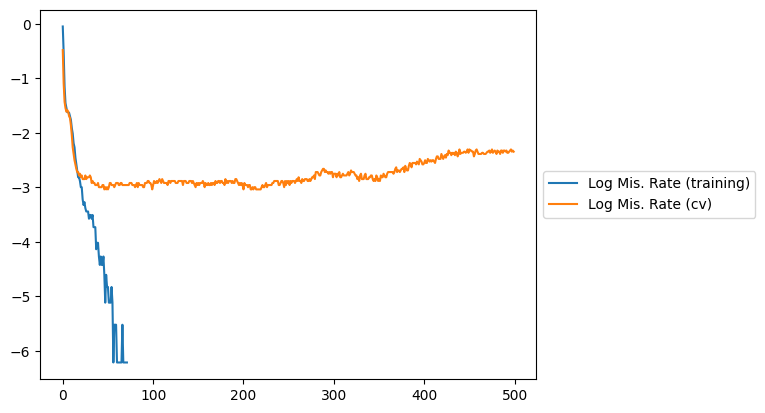

In [10]:
plt.plot(np.log(train_miss_rates))
plt.plot(np.log(val_miss_rates))

plt.legend(
    ["Log Mis. Rate (training)", "Log Mis. Rate (cv)"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.show()

In [11]:
# Merge training and cv dataset
train_indices = [range(0 + 200 * i, 100 + 200 * i) for i in range(10)]
X_train = X[train_indices,].reshape(1000, 241)

# Create class labels for prediction
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [12]:
# Reinitialize parameters
epochs = 100
neurons_1 = 256
neurons_2 = 128
neurons_3 = 128
input_layer = InputLayer()
fc_layer1 = FullyConnectedLayer(
    X.shape[1], neurons_1, activation_func="tanh", add_noise=True
)
fc_layer2 = FullyConnectedLayer(
    neurons_1, neurons_2, activation_func="tanh", add_noise=True
)
fc_layer3 = FullyConnectedLayer(
    neurons_2, neurons_3, activation_func="tanh", add_noise=True
)
output_layer = Softmax(neurons_3, 10)

mlp = MLP([input_layer, fc_layer1, fc_layer2, fc_layer3, output_layer])

In [13]:
train_miss_rates = []

for epoch in range(epochs):
    mlp.forward(X_train)
    mlp.backward(y_matrix, eta=0.1)

    train_miss_rates.append(
        misclassification_rate(
            np.argmax(y_matrix, axis=1), np.argmax(mlp.predict_label(), axis=1)
        )
    )

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Training MSE: {train_miss_rates[epoch]}")

Epoch 0: Training MSE: 0.946
Epoch 10: Training MSE: 0.205
Epoch 20: Training MSE: 0.154
Epoch 30: Training MSE: 0.078
Epoch 40: Training MSE: 0.057
Epoch 50: Training MSE: 0.047
Epoch 60: Training MSE: 0.039
Epoch 70: Training MSE: 0.034
Epoch 80: Training MSE: 0.033
Epoch 90: Training MSE: 0.025


In [14]:
mlp.forward(X_test)
test_miss_rate = misclassification_rate(
    np.argmax(y_matrix, axis=1), np.argmax(mlp.predict_label(), axis=1)
)
print(f"The misclassification rate on the test dataset is: {test_miss_rate:0.02}")

The misclassification rate on the test dataset is: 0.044
